# AUTHOR: Rajesh Bondugula

### Sigmoid function

- A sigmoid function is a mathematical function having an "S" shape (sigmoid curve).
- It converts any real values number to a fraction in range (0 1) conviniently usable for probabilities.
- It is real-valued and differentiable, having a non-negative or non-positive first derivative
- It has one local minimum, and one local maximum.
- Hence it gives the convex shape and hence finding minimum / maximum is easy with gradient descent or accent.
- Center of Sigmoid occurs at x = 0 and the value is 0.5
- Sigmoid function is given as follows

$$
h\left(x\right)=\frac{1}{1 + e^{-x}}
$$

In [9]:
# Import numpy and matplotlib modiules.
import scipy.special as scp_spl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

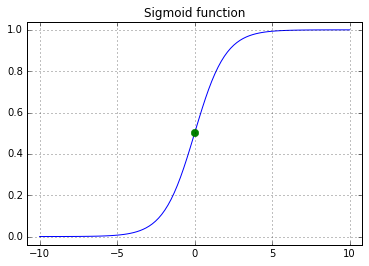

In [28]:
# plot the sigmoid function
x = np.linspace(-10, 10, 100)
y = scp_spl.expit(x) # y = 1 / (1 + np.exp(-x))
plt.plot(x, y)
plt.plot(0, scp_spl.expit(0), 'g.', markersize=15)
plt.margins(0.04)
plt.grid()
plt.title("Sigmoid function")
